# 10.2 注意力汇聚:Nadaraya-Watson核回归



In [1]:
import torch
from torch import nn
from d2l import torch as d2l

## 10.2.1 生成数据集



In [2]:
n_train = 50 # 训练样本数
x_train,_ = torch.sort(torch.rand(n_train)*5) # 排序后的训练样本
def f(x):
    return 2 * torch.sin(x) + x**0.8
y_train = f(x_train) + torch.normal(0.0,0.5,(n_train,)) # 训练样本的输出
x_test = torch.arange(0,5,0.1) # 测试样本
y_truth = f(x_test) # 测试样本的真实输出
n_test = len(x_test)
n_test

50

下面的函数将绘制所有的训练样本，不带噪声项的真实数据生成函数f(标记为'Truth')，以及学习得到的预测函数(标记为'Pred')

In [3]:
def plot_kernel_reg(y_hat):
    d2l.plot(x_test,[y_truth,y_hat],'x','y',legend=['Truth','Pred'],
             xlim=[0,5],ylim=[-1,5])
    d2l.plt.plot(x_train,y_train,'o',alpha=0.5)

## 10.2.2 平均汇聚

基于平均汇聚计算所有训练样本输出值的平均值

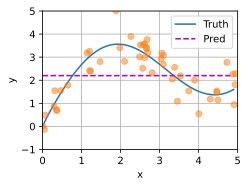

In [4]:
y_hat = torch.repeat_interleave(y_train.mean(),n_test)
plot_kernel_reg(y_hat)

## 10.2.3 非参数注意力汇聚

注意力汇聚(attention pooling)公式见课本

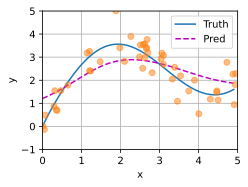

In [5]:
# X_repeat的形状为(n_test,n_train)
# 每一行都包含相同的测试输入(例如同样的查询) 每一行都是同样的测试样本
X_repeat = x_test.repeat_interleave(n_train).reshape((-1,n_train))
# x_train包含键。attention_weights的形状为(n_test,n_train)
# 每一行都包含要在给定的每个查询的值(y_train)之间分配的注意力权重
attention_weights = nn.functional.softmax(-(X_repeat-x_train)**2/2,dim=1)
# y_hat的每个元素都是值的加权平均值，其中的权重是注意力权重
y_hat = torch.matmul(attention_weights,y_train)
plot_kernel_reg(y_hat)

“查询-键”对越接近，注意力汇聚的注意力权重就越高

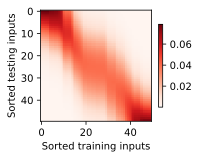

In [6]:
d2l.show_heatmaps(attention_weights.unsqueeze(0).unsqueeze(0),
                  xlabel='Sorted training inputs',
                  ylabel='Sorted testing inputs')

这里的两次unsqueeze的使用为attention_weights增加了两个维度

原来的attention_weights的形状为(num_test,num_train)，在使用unsqueeze之后，变为(batch_size,num_heads,num_test,num_train)

这与后面的多头注意力可能相关，即使只有单组注意力权重（单头），也需要显式添加额外的维度

## 10.2.4 带参数注意力汇聚

非参数的Madaraya-Watson核回归具有一致性的优点：如果有足够多的数据，此模型会收敛到最优结果

本小节将上一节中查询$x$和键$x_i$之间的距离乘以可学习的参数$w$

**1.批量矩阵乘法**

假定两个张量的形状分别为(n,a,b)和(n,b,c)，它们的批量矩阵乘法输出的形状为(n,a,c)

In [7]:
X = torch.ones((2,1,4))
Y = torch.ones((2,4,6))
torch.bmm(X,Y).shape

torch.Size([2, 1, 6])

在注意力机制的背景下，我们可以使用小批量矩阵乘法来计算小批量数据中的加权平均值

In [8]:
weights = torch.ones((2,10)) * 0.1
values = torch.arange(20.0).reshape((2,10))
torch.bmm(weights.unsqueeze(1),values.unsqueeze(-1)) # (2,1,10) x (2,10,1)

tensor([[[ 4.5000]],

        [[14.5000]]])

**2.定义模型**



In [9]:
class NWKernelRegression(nn.Module):
    def __init__(self,**kwargs):
        super().__init__(**kwargs)
        self.w = nn.Parameter(torch.rand((1,),requires_grad=True))

    def forward(self,queries,keys,values):
        # quires和attention_weights的形状为(查询数，键-值对数)
        queries = queries.repeat_interleave(keys.shape[1]).reshape((-1,
                                                                    keys.shape[1]))
        self.attention_weights = nn.functional.softmax(
            -((queries-keys)*self.w) ** 2 / 2 ,dim=1
        )
        # value 的形状为(查询数，键-值对数)
        return torch.bmm(self.attention_weights.unsqueeze(1),
                        values.unsqueeze(-1)).reshape(-1)

**3.训练**



In [10]:
# X_tile的形状为(n_train,n_train)，每一行都包含相同的训练输入
X_tile = x_train.repeat((n_train,1))
# Y_tile的形状为(n_train,n_train)，每一行都包含相同的训练输出
Y_tile = y_train.repeat((n_train,1))
# keys的形状为('n_train','n_train'-1)
keys = X_tile[(1-torch.eye(n_train)).type(torch.bool)].reshape((n_train,-1))
# values的形状为('n_train','n_train'-1)
values = Y_tile[(1-torch.eye(n_train)).type(torch.bool)].reshape((n_train,-1))

训练带参数的注意力汇聚模型时，使用平方损失函数和随机梯度下降

In [11]:
net = NWKernelRegression()
loss = nn.MSELoss(reduction='none')
trainer = torch.optim.SGD(net.parameters(), lr=0.5)
animator = d2l.Animator(xlabel='epoch',ylabel='loss',xlim=[1,5])

for epoch in range(5):
    trainer.zero_grad()
    l = loss(net(x_train,keys,values),y_train)
    l.sum().backward()
    trainer.step()
    print(f'epoch {epoch+1},loss {float(l.sum()):.6f}')
    animator.add(epoch+1,float(l.sum()))

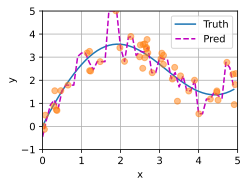

In [12]:
# keys的形状为(n_test,n_train)，每一行包含相同的训练输入(例如，相同的键)
keys = x_train.repeat((n_test,1))
# value的形状为(n_test,n_train)
values = y_train.repeat((n_test,1))
y_hat = net(x_test,keys,values).unsqueeze(-1).detach()
plot_kernel_reg(y_hat)

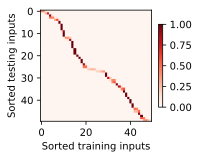

In [13]:
d2l.show_heatmaps(net.attention_weights.unsqueeze(0).unsqueeze(0),
                  xlabel='Sorted training inputs',
                  ylabel='Sorted testing inputs')

**总结**
- NW核回归是具有注意力机制的机器学习范例
- NW核回归的注意力汇聚是对训练数据输出的加权平均。从注意力的角度来看，分配给每个值得注意力权重将取决于将值所对应的键和查询作为输入的函数
- 注意力汇聚可以分为非参数型和带参数型